In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import GPy
import casadi as ca
import torch
import torch.nn as nn
import torch.optim as optim
import time

import japanize_matplotlib
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.figsize'] = (8, 8)

# ==================================================================================
# シミュレーション全体の設定パラメータ
# ==================================================================================
N_ITERATIONS = 5
SIM_STEPS = 100
DT = 0.1
NX, NU = 4, 2
START_STATE = np.array([0.0, 0.0, 0.0, 0.0])
GOAL_STATE_POS = np.array([10.0, 10.0])
GOAL_STATE = np.hstack([GOAL_STATE_POS, 0, 0])
N_MPC = 25
M_MPC = 10
OBSTACLE_INFO = {'pos': np.array([5.0, 5.0]), 'rad': 1.5}

CERTIFICATE_C = 2.5 # V(x) <= c の制約値
GAMMA = 0.98         # 割引率

In [ ]:
class NNCallback(ca.Callback):
    """CasADiからPyTorchのNNを呼び出すためのクラス"""
    def __init__(self, name, nn_model, opts={}):
        ca.Callback.__init__(self)
        self.nn_model = nn_model
        self.construct(name, opts)
    def get_n_in(self): return 1
    def get_n_out(self): return 1
    def get_sparsity_in(self, i): return ca.Sparsity.dense(NX, 1)
    def get_sparsity_out(self, i): return ca.Sparsity.dense(1, 1)
    def eval(self, arg):
        x = np.array(arg[0])
        x_torch = torch.tensor(x, dtype=torch.float32).T
        with torch.no_grad():
            cost = self.nn_model(x_torch).numpy()
        return [cost]

In [ ]:
class CertificateNN(nn.Module):
    """論文のV(x)に対応するネットワーク"""
    def __init__(self, n_input,scale):
        super(CertificateNN, self).__init__()
        self.w = nn.Sequential(
            nn.Linear(n_input, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, 4)
        )
        self.scale=scale
    def forward(self, x):
        w_x = self.w(x)
        return self.scale * torch.sum(w_x**2, dim=1, keepdim=True)

In [4]:
class Pi_NN(nn.Module):
    """論文の制御方策π(x)に対応するネットワーク"""
    def __init__(self, n_input, n_output):
        super(Pi_NN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(n_input, 32), nn.Tanh(),
            nn.Linear(32, 32), nn.Tanh(),
            nn.Linear(32, n_output)
        )
    def forward(self, x):
        return self.layers(x)

In [ ]:
def train_certificate_net(v_net, pi_net, all_past_data, gpr_model, obstacle_info):
    """(10)式に基づいた損失関数でNNを学習する関数"""
    if not all_past_data: return
    print("NN証明書: 学習開始...")
    params = list(v_net.parameters()) + list(pi_net.parameters())
    optimizer = optim.Adam(params, lr=1e-4)
    safe_states = torch.tensor(np.array([d[0] for d in all_past_data]), dtype=torch.float32)
    num_unsafe = len(safe_states) // 2
    unsafe_points = np.random.randn(num_unsafe, 2) * obstacle_info['rad'] + obstacle_info['pos']
    unsafe_states = torch.tensor(np.hstack([unsafe_points, np.zeros((num_unsafe, 2))]), dtype=torch.float32)

    def stage_cost_func(x, u):
        goal_pos_tensor = torch.tensor(GOAL_STATE_POS, dtype=torch.float32)
        pos_error = torch.sum((x[:, :2] - goal_pos_tensor)**2, dim=1, keepdim=True)
        input_cost = torch.sum(u**2, dim=1, keepdim=True)
        return pos_error * DT + input_cost * DT * 0.01
    def f_gpr(x, u):
        error_mean, _ = gpr_model.predict(x.detach().numpy(), u.detach().numpy())
        error_mean_tensor = torch.tensor(error_mean, dtype=torch.float32)
        delta_nominal = torch.cat([x[:, 2:], u], dim=1)
        delta_pred = delta_nominal + error_mean_tensor
        return x + delta_pred * DT

    for epoch in range(500):
        optimizer.zero_grad()
        loss_goal = v_net(torch.tensor(GOAL_STATE, dtype=torch.float32).unsqueeze(0))
        v_safe = v_net(safe_states); v_unsafe = v_net(unsafe_states)
        loss_safe_boundary = torch.mean(torch.relu(v_safe - CERTIFICATE_C))
        loss_unsafe_boundary = torch.mean(torch.relu(CERTIFICATE_C - v_unsafe))
        u_pi_safe = pi_net(safe_states); x_next_safe = f_gpr(safe_states, u_pi_safe)
        v_next_safe = v_net(x_next_safe); stage_costs = stage_cost_func(safe_states, u_pi_safe)
        loss_lyapunov = torch.mean(torch.relu(GAMMA * v_next_safe - v_safe + stage_costs))
        total_loss = loss_goal + loss_safe_boundary + loss_unsafe_boundary + loss_lyapunov
        total_loss.backward(); optimizer.step()
    print(f"NN certificates: 学習完了。最終損失: {total_loss.item():.4f}")

    print("最大V_safe:", v_safe.max().item())
    print("最小V_safe:", v_safe.min().item())
    print("V(goal):", loss_goal.item())


In [6]:
class TrueVehicle:
    def __init__(self, dt=0.1): self.dt = dt
    def dynamics(self, x, u):
        px, py, vx, vy = x; ax, ay = u; drag = 0.1
        vx_next = vx + (ax - drag * vx**2) * self.dt; vy_next = vy + (ay - drag * vy**2) * self.dt
        px_next = px + vx * self.dt + 0.5 * ax * self.dt**2; py_next = py + vy * self.dt + 0.5 * ay * self.dt**2
        return np.array([px_next, py_next, vx_next, vy_next])
class GPRModel:
    def __init__(self, nx, nu):
        self.nx, self.nu = nx, nu; self.is_trained = False
        self.X_data = np.empty((0, self.nx + self.nu)); self.Y_data = np.empty((0, self.nx))
        self.models = [None] * self.nx
    def add_data(self, x, u, x_next):
        delta_real = (x_next - x) / DT; delta_nominal = np.array([x[2], x[3], u[0], u[1]])
        error = delta_real - delta_nominal
        self.X_data = np.vstack([self.X_data, np.hstack([x, u])]); self.Y_data = np.vstack([self.Y_data, error])
    def train(self):
        if len(self.X_data) < 10: return
        print("GPR: 学習開始..."); self.is_trained = True
        for i in range(self.nx):
            kernel = GPy.kern.RBF(input_dim=self.nx + self.nu, ARD=True)
            model = GPy.models.GPRegression(self.X_data, self.Y_data[:, i:i+1], kernel)
            model.optimize(messages=False, max_iters=100); self.models[i] = model
        print("GPR: 学習完了")
    def predict(self, x, u):
        if not self.is_trained: return np.zeros(self.nx), np.ones(self.nx)
        xu = np.hstack([x, u]).reshape(1, -1)
        means = np.array([m.predict(xu)[0][0, 0] if m else 0 for m in self.models])
        variances = np.array([m.predict(xu)[1][0, 0] if m else 1.0 for m in self.models])
        return means, variances

In [ ]:
class MPCController:
    def __init__(self, nx, nu, N, M, dt, obstacle_info):
        self.nx, self.nu, self.N, self.M, self.dt = nx, nu, N, M, dt
        self.obstacle_info = obstacle_info; self.u_prev_sol = np.zeros((nu, N))

    def solve(self, x_current, gpr_model, x_goal_pos, certificate_net, is_first_iteration):
        opti = ca.Opti(); U = opti.variable(self.nu, self.N)
        terminal_cost_func = NNCallback('terminal_cost_func', certificate_net)
        error_mean, error_var = gpr_model.predict(x_current, np.zeros(self.nu))
        #error_std = np.sqrt(np.maximum(error_var, 1e-6)); error_std_capped = np.minimum(error_std, 0.2)
        error_std = np.sqrt(np.maximum(error_var, 1e-6)); error_std_capped = np.minimum(error_std, 0.01)
        error_samples = np.random.normal(loc=error_mean, scale=error_std_capped, size=(self.M, self.nx))
        all_scenario_costs = []
        for m in range(self.M):
            X_scenario = opti.variable(self.nx, self.N + 1); cost_scenario = 0
            opti.subject_to(X_scenario[:, 0] == x_current)
            for k in range(self.N):
                x_k, u_k = X_scenario[:, k], U[:, k]
                delta_nominal = ca.vertcat(x_k[2], x_k[3], u_k[0], u_k[1])
                delta_pred = delta_nominal + error_samples[m, :]
                x_next_pred = x_k + delta_pred * self.dt
                opti.subject_to(X_scenario[:, k+1] == x_next_pred)
                if is_first_iteration:
                    stage_pos_weight = 1.0; stage_input_weight = 0.5; obstacle_weight = 2000.0
                else:
                    stage_pos_weight = 1.0; stage_input_weight = 0.01; obstacle_weight = 500.0
                cost_scenario += ca.sumsqr(x_k[:2] - x_goal_pos) * self.dt * stage_pos_weight
                cost_scenario += ca.sumsqr(u_k) * self.dt * stage_input_weight
                if self.obstacle_info:
                    dist_to_obs = ca.norm_2(x_k[:2] - self.obstacle_info['pos'])
                    if is_first_iteration:
                        safety_margin = 0.8; keep_out_radius = self.obstacle_info['rad'] + safety_margin
                        opti.subject_to(dist_to_obs >= keep_out_radius)
                    else:
                        penalty = ca.fmax(0, self.obstacle_info['rad'] - dist_to_obs)
                        cost_scenario += obstacle_weight * penalty**2
            terminal_state = X_scenario[:, self.N]
            if is_first_iteration:
                cost_scenario += ca.sumsqr(terminal_state[:2] - x_goal_pos) * 10.0
            else:
                terminal_cost = terminal_cost_func(terminal_state)
                cost_scenario += terminal_cost*50
                terminal_constraint_violation = ca.fmax(0, terminal_cost - CERTIFICATE_C)
                cost_scenario += 1000.0 * terminal_constraint_violation
            all_scenario_costs.append(cost_scenario)
        #total_objective = ca.mean(ca.vertcat(*all_scenario_costs))
        total_objective = ca.sum1(ca.vertcat(*all_scenario_costs)) / len(all_scenario_costs)
        opti.minimize(total_objective)
        opti.subject_to(opti.bounded(-5.0, U, 5.0))
        opti.set_initial(U, self.u_prev_sol)
        s_opts = {'print_level': 0}; opti.solver('ipopt', {}, s_opts)
        try:
            sol = opti.solve()
            self.u_prev_sol = np.hstack((sol.value(U)[:, 1:], sol.value(U)[:, -1].reshape(-1, 1)))
            return sol.value(U[:, 0])
        except Exception as e:
            print(f"MPC: 最適化失敗。x={x_current}"); return np.zeros(self.nu)

In [ ]:
def visualize_Vx(certificate_net, title='V(x) 可視化', resolution=100, c_level=1.0):
    import matplotlib.pyplot as plt
    import numpy as np
    import torch

    # 可視化範囲設定（x, y 位置のみ）
    x_vals = np.linspace(-2, 12, resolution)
    y_vals = np.linspace(-2, 12, resolution)
    X, Y = np.meshgrid(x_vals, y_vals)

    # 他の状態変数 (vx, vy) は 0 固定で可視化
    vx = 0.0
    vy = 0.0
    all_points = np.stack([X.ravel(), Y.ravel(),
                           np.full_like(X.ravel(), vx),
                           np.full_like(Y.ravel(), vy)], axis=1)
    
    with torch.no_grad():
        points_tensor = torch.tensor(all_points, dtype=torch.float32)
        v_values = certificate_net(points_tensor).numpy().reshape(X.shape)

    plt.figure(figsize=(8, 6))
    contour = plt.contourf(X, Y, v_values, levels=100, cmap='viridis')
    cbar = plt.colorbar(contour)
    cbar.set_label('V(x)')

    # 制約境界 V(x) = CERTIFICATE_C の等高線を描く
    contour2 = plt.contour(X, Y, v_values, levels=[c_level], colors='r', linewidths=2)
    plt.clabel(contour2, fmt='V(x)=%.2f' % c_level, colors='r')

    plt.xlabel('x位置')
    plt.ylabel('y位置')
    plt.title(title)
    plt.axis('equal')
    plt.grid(True)
    plt.show()

In [ ]:
def main():
    vehicle = TrueVehicle(dt=DT); gpr_model = GPRModel(nx=NX, nu=NU)
    mpc = MPCController(nx=NX, nu=NU, N=N_MPC, M=M_MPC, dt=DT, obstacle_info=OBSTACLE_INFO)
    
    certificate_net = CertificateNN(n_input=NX, scale=0.01)
    policy_net = Pi_NN(n_input=NX, n_output=NU)
    all_trajectories, final_costs = [], []; all_past_data = []

    for i in range(N_ITERATIONS):
        print(f"\n{'='*50}\n反復学習: イテレーション {i+1}/{N_ITERATIONS}\n{'='*50}")
        current_x = np.copy(START_STATE); total_cost = 0; iteration_data = []
        for step in range(SIM_STEPS):
            is_first_iter = (i == 0)
            u_optimal = mpc.solve(current_x, gpr_model, GOAL_STATE_POS, certificate_net, is_first_iter)
            x_next = vehicle.dynamics(current_x, u_optimal)
            stage_cost = (np.sum((current_x[:2] - GOAL_STATE_POS)**2) + np.sum(u_optimal**2) * 0.2) * DT
            total_cost += stage_cost
            iteration_data.append((current_x, u_optimal, x_next, stage_cost))
            current_x = x_next
            if np.linalg.norm(current_x[:2] - GOAL_STATE_POS) < 0.5:
                print(f"ステップ {step+1} でゴールに到達！"); break
        
        current_trajectory_states = [d[0] for d in iteration_data]
        all_trajectories.append(np.array(current_trajectory_states))
        final_costs.append(total_cost)
        print(f"イテレーション {i+1} の総コスト: {total_cost:.2f}")
        
        gpr_data_for_train = [(d[0], d[1], d[2]) for d in iteration_data]
        for x, u, x_n in gpr_data_for_train: gpr_model.add_data(x, u, x_n)
        gpr_model.train()
        
        cost_data_for_train = [(d[0], d[3]) for d in iteration_data]
        all_past_data.extend(cost_data_for_train)
        train_certificate_net(certificate_net, policy_net, all_past_data, gpr_model, OBSTACLE_INFO)

    plt.figure(figsize=(10, 10))
    if OBSTACLE_INFO:
        obs_circle = plt.Circle(OBSTACLE_INFO['pos'], OBSTACLE_INFO['rad'], color='r', alpha=0.5, label='障害物')
        plt.gca().add_patch(obs_circle)
    plt.plot(START_STATE[0], START_STATE[1], 'go', markersize=15, label='スタート')
    plt.plot(GOAL_STATE_POS[0], GOAL_STATE_POS[1], 'm*', markersize=20, label='ゴール')
    for i, traj in enumerate(all_trajectories):
        plt.plot(traj[:, 0], traj[:, 1], '-o', markersize=3, label=f'イテレーション {i+1}')
    plt.title('走行軌跡（論文ベースのNN certificates版）'); plt.legend(); plt.axis('equal'); plt.show()
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, N_ITERATIONS + 1), final_costs, '-ro')
    plt.title('イテレーションごとの総コストの推移'); plt.xlabel('イテレーション回数')
    plt.ylabel('総コスト'); plt.xticks(range(1, N_ITERATIONS + 1)); plt.show()
    visualize_Vx(certificate_net, c_level=CERTIFICATE_C)


反復学習: イテレーション 1/5

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   1.00ms ( 20.41us)   1.97ms ( 40.31us)        49
       nlp_g  |  11.00ms (224.49us)   3.23ms ( 65.96us)        49
  nlp_grad_f  |   2.00ms ( 40.00us)   2.67ms ( 53.44us)        50
  nlp_hess_l  |   6.00ms (125.00us)   7.44ms (155.06us)        48
   nlp_jac_g  |   9.00ms (180.00us)  12.89ms (257.72us)        50
       total  | 275.00ms (275.00ms) 260.51ms (260.51ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)   1.15ms ( 44.31us)        26


 c:\Users\sakurai\abc\Lib\site-packages\GPy\kern\src\stationary.py:166: RuntimeWarning:overflow encountered in divide
 c:\Users\sakurai\abc\Lib\site-packages\GPy\kern\src\stationary.py:137: RuntimeWarning:overflow encountered in square
 c:\Users\sakurai\abc\Lib\site-packages\GPy\kern\src\stationary.py:138: RuntimeWarning:invalid value encountered in add
 c:\Users\sakurai\abc\Lib\site-packages\GPy\kern\src\rbf.py:178: RuntimeWarning:invalid value encountered in multiply


GPR: 学習完了
NN証明書: 学習開始...
NN証明書: 学習完了。最終損失: 7.6816
最大V_safe: 1.9820705652236938
最小V_safe: 0.3915111720561981
V(goal): 0.1349542737007141

反復学習: イテレーション 2/5
MPC: 最適化失敗。x=[0. 0. 0. 0.]
MPC: 最適化失敗。x=[0. 0. 0. 0.]
MPC: 最適化失敗。x=[0. 0. 0. 0.]
MPC: 最適化失敗。x=[0. 0. 0. 0.]
MPC: 最適化失敗。x=[0. 0. 0. 0.]
MPC: 最適化失敗。x=[0. 0. 0. 0.]
MPC: 最適化失敗。x=[0. 0. 0. 0.]
MPC: 最適化失敗。x=[0. 0. 0. 0.]
MPC: 最適化失敗。x=[0. 0. 0. 0.]
MPC: 最適化失敗。x=[0. 0. 0. 0.]
MPC: 最適化失敗。x=[0. 0. 0. 0.]
MPC: 最適化失敗。x=[0. 0. 0. 0.]
MPC: 最適化失敗。x=[0. 0. 0. 0.]
MPC: 最適化失敗。x=[0. 0. 0. 0.]
MPC: 最適化失敗。x=[0. 0. 0. 0.]
MPC: 最適化失敗。x=[0. 0. 0. 0.]
MPC: 最適化失敗。x=[0. 0. 0. 0.]
MPC: 最適化失敗。x=[0. 0. 0. 0.]
MPC: 最適化失敗。x=[0. 0. 0. 0.]
MPC: 最適化失敗。x=[0. 0. 0. 0.]
MPC: 最適化失敗。x=[0. 0. 0. 0.]
MPC: 最適化失敗。x=[0. 0. 0. 0.]
MPC: 最適化失敗。x=[0. 0. 0. 0.]
MPC: 最適化失敗。x=[0. 0. 0. 0.]
MPC: 最適化失敗。x=[0. 0. 0. 0.]
MPC: 最適化失敗。x=[0. 0. 0. 0.]
MPC: 最適化失敗。x=[0. 0. 0. 0.]
MPC: 最適化失敗。x=[0. 0. 0. 0.]
MPC: 最適化失敗。x=[0. 0. 0. 0.]
MPC: 最適化失敗。x=[0. 0. 0. 0.]
MPC: 最適化失敗。x=[0. 0. 0. 0.]
MPC: 最適化

 c:\Users\sakurai\abc\Lib\site-packages\GPy\kern\src\stationary.py:243: RuntimeWarning:invalid value encountered in divide


GPR: 学習完了
NN証明書: 学習開始...
NN証明書: 学習完了。最終損失: 13.9340
最大V_safe: 3.688504934310913
最小V_safe: 0.3196255564689636
V(goal): 0.003951001446694136

反復学習: イテレーション 3/5
MPC: 最適化失敗。x=[0. 0. 0. 0.]
MPC: 最適化失敗。x=[0. 0. 0. 0.]
MPC: 最適化失敗。x=[0. 0. 0. 0.]
MPC: 最適化失敗。x=[0. 0. 0. 0.]
MPC: 最適化失敗。x=[0. 0. 0. 0.]
MPC: 最適化失敗。x=[0. 0. 0. 0.]
MPC: 最適化失敗。x=[0. 0. 0. 0.]
MPC: 最適化失敗。x=[0. 0. 0. 0.]
MPC: 最適化失敗。x=[0. 0. 0. 0.]
MPC: 最適化失敗。x=[0. 0. 0. 0.]
MPC: 最適化失敗。x=[0. 0. 0. 0.]
MPC: 最適化失敗。x=[0. 0. 0. 0.]
MPC: 最適化失敗。x=[0. 0. 0. 0.]
MPC: 最適化失敗。x=[0. 0. 0. 0.]
MPC: 最適化失敗。x=[0. 0. 0. 0.]
MPC: 最適化失敗。x=[0. 0. 0. 0.]
MPC: 最適化失敗。x=[0. 0. 0. 0.]
MPC: 最適化失敗。x=[0. 0. 0. 0.]
MPC: 最適化失敗。x=[0. 0. 0. 0.]
MPC: 最適化失敗。x=[0. 0. 0. 0.]
MPC: 最適化失敗。x=[0. 0. 0. 0.]
MPC: 最適化失敗。x=[0. 0. 0. 0.]
MPC: 最適化失敗。x=[0. 0. 0. 0.]
MPC: 最適化失敗。x=[0. 0. 0. 0.]
MPC: 最適化失敗。x=[0. 0. 0. 0.]
MPC: 最適化失敗。x=[0. 0. 0. 0.]
MPC: 最適化失敗。x=[0. 0. 0. 0.]
MPC: 最適化失敗。x=[0. 0. 0. 0.]
MPC: 最適化失敗。x=[0. 0. 0. 0.]
MPC: 最適化失敗。x=[0. 0. 0. 0.]
MPC: 最適化失敗。x=[0. 0. 0. 0.]
MPC: 最

 c:\Users\sakurai\abc\Lib\site-packages\GPy\kern\src\stationary.py:166: RuntimeWarning:overflow encountered in divide
 c:\Users\sakurai\abc\Lib\site-packages\GPy\kern\src\stationary.py:137: RuntimeWarning:overflow encountered in square
 c:\Users\sakurai\abc\Lib\site-packages\GPy\kern\src\stationary.py:138: RuntimeWarning:invalid value encountered in add
 c:\Users\sakurai\abc\Lib\site-packages\GPy\kern\src\rbf.py:178: RuntimeWarning:invalid value encountered in multiply


GPR: 学習完了
NN証明書: 学習開始...
NN証明書: 学習完了。最終損失: 15.8529
最大V_safe: 3.711357831954956
最小V_safe: 0.1414494514465332
V(goal): 5.0268794439034536e-05

反復学習: イテレーション 5/5
MPC: 最適化失敗。x=[0. 0. 0. 0.]
MPC: 最適化失敗。x=[0. 0. 0. 0.]
MPC: 最適化失敗。x=[0. 0. 0. 0.]
MPC: 最適化失敗。x=[0. 0. 0. 0.]
MPC: 最適化失敗。x=[0. 0. 0. 0.]
MPC: 最適化失敗。x=[0. 0. 0. 0.]
MPC: 最適化失敗。x=[0. 0. 0. 0.]
MPC: 最適化失敗。x=[0. 0. 0. 0.]
MPC: 最適化失敗。x=[0. 0. 0. 0.]
MPC: 最適化失敗。x=[0. 0. 0. 0.]
MPC: 最適化失敗。x=[0. 0. 0. 0.]
MPC: 最適化失敗。x=[0. 0. 0. 0.]
MPC: 最適化失敗。x=[0. 0. 0. 0.]
MPC: 最適化失敗。x=[0. 0. 0. 0.]
MPC: 最適化失敗。x=[0. 0. 0. 0.]
MPC: 最適化失敗。x=[0. 0. 0. 0.]
MPC: 最適化失敗。x=[0. 0. 0. 0.]
MPC: 最適化失敗。x=[0. 0. 0. 0.]
MPC: 最適化失敗。x=[0. 0. 0. 0.]
MPC: 最適化失敗。x=[0. 0. 0. 0.]
MPC: 最適化失敗。x=[0. 0. 0. 0.]
MPC: 最適化失敗。x=[0. 0. 0. 0.]
MPC: 最適化失敗。x=[0. 0. 0. 0.]
MPC: 最適化失敗。x=[0. 0. 0. 0.]
MPC: 最適化失敗。x=[0. 0. 0. 0.]
MPC: 最適化失敗。x=[0. 0. 0. 0.]
MPC: 最適化失敗。x=[0. 0. 0. 0.]
MPC: 最適化失敗。x=[0. 0. 0. 0.]
MPC: 最適化失敗。x=[0. 0. 0. 0.]
MPC: 最適化失敗。x=[0. 0. 0. 0.]
MPC: 最適化失敗。x=[0. 0. 0. 0.]
MPC:

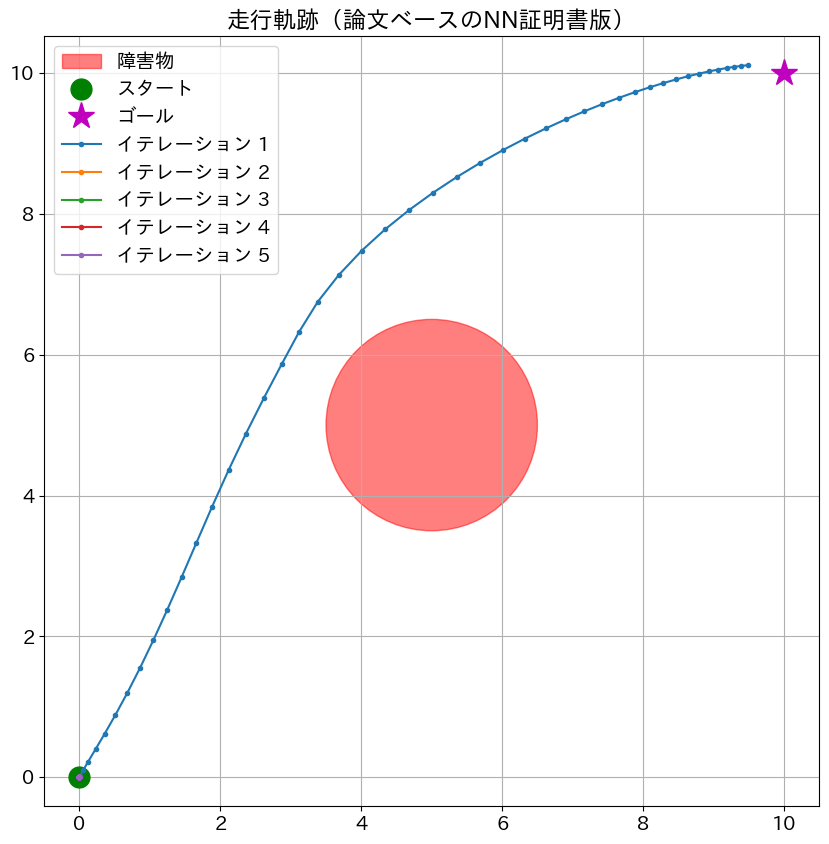

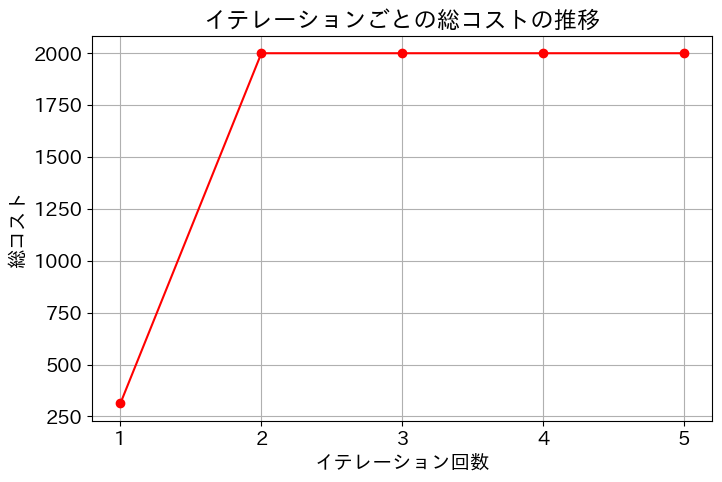

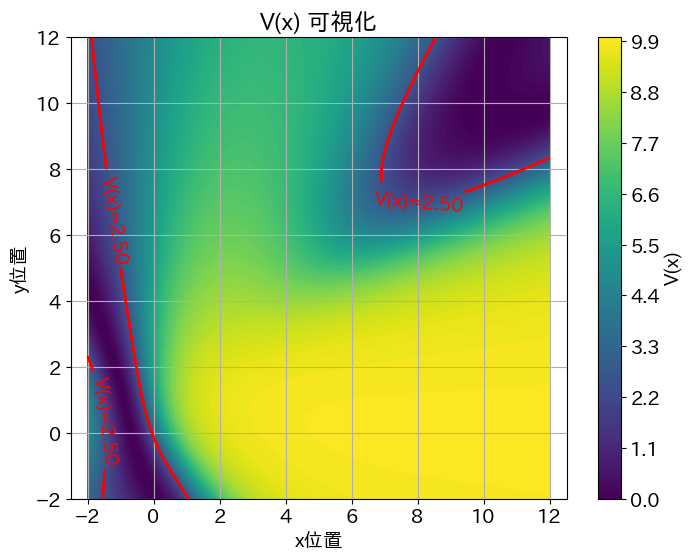

In [10]:
if __name__ == '__main__':
    main()